In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy.plotting import plot3d
import pyaudio

In [2]:
class play_wave:
        def __init__(self):
            self.p = pyaudio.PyAudio()
            self.stream = self.p.open(format=pyaudio.paFloat32, channels=1, rate=44100, output=1)
        def close(self):
            self.stream.close()
            self.p.terminate()
        def play(self, signal):
            signal *= 0.1
            self.stream.write(signal.astype(np.float32).tostring())

In [3]:
class create_waon:
    def __init__(self):
        return
    def sine(self, frequency, length, rate):
        length = int(length * rate)
        factor = float(frequency) * (np.pi * 2) / rate
        return np.sin(np.arange(length) * factor)
    def return_waon(self, nums, levels):
        result = np.zeros(44100)
        for i, (n, l) in enumerate(zip(nums, levels)):
            s = 44100 - int(44100 * (1-0.1*i))
            result[s: ] += self.sine(440 * (2 ** (1/12)) ** n , 1 - 0.1*i, 44100) * l
        return result
    def major(self, pitch):
        return self.return_waon([pitch, pitch+4, pitch+7], [1,1,1])
    def minor(self, pitch):
        return self.return_waon([pitch, pitch+3, pitch+7], [1,1,1])
    def dim(self, pitch):
        return self.return_waon([pitch, pitch+3, pitch+6], [1,1,1])
    def aug(self, pitch):
        return self.return_waon([pitch, pitch+4, pitch+8], [1,1,1])

In [4]:
def create_plane(a, b, c):
    ab = b - a
    ac = c - a
    normal = np.cross(ab, ac)
    return normal

In [5]:
def random_plane():
    normal = np.zeros(3,)
    
    while(normal[0] == 0 or normal[2] == 0):
        a = np.array([0,0,0])
        b = np.random.randint(-5,5,(3,))
        c = np.random.randint(-5,5,(3,))
        normal = create_plane(a,b,c)
        
    return normal

def plot_plane(normal):
    d = - 1 * np.zeros(3,).dot(normal)
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

    n = np.outer(normal, np.arange(-2,2,0.1)) + np.array([[0],[0],[z[10,10]]])

    plt3d = plt.figure(figsize=(6,6)).gca(projection='3d')
    plt3d.plot_surface(xx, yy, z, alpha = 0.7)
    plt3d.plot(n[0],n[1],n[2], color="red", ms=4, mew=1)
    plt3d.view_init(0,0)
    plt3d.set_xlabel("X-axis")
    plt3d.set_ylabel("Y-axis")
    plt3d.set_zlabel("Z-axis")
    plt.plot([0],[0],[z[10,10]], color="blue", marker = ".", ms=15, mew = 1)
    plt.show()

In [6]:
def plane_sound():
    normal = random_plane()
    #normal = np.array([5,0,5])
    #plot_plane(normal)

    eyes = (10,0,0)
    face = sp.Plane(sp.Point3D(eyes), normal_vector = eyes)

    p = sp.Plane(sp.Point3D(0,0,0), normal_vector = normal)
    l = sp.Line3D(sp.Point3D(eyes), sp.Point3D(0,0,0))
    nl = sp.Line3D(p.intersection(l)[0], direction_ratio = normal)

    point = face.intersection(nl)
    #print(point[0].evalf())
    x, y, z = float(point[0].x), float(point[0].y), float(point[0].z)
    if y == 0:
        angle = 90 * np.sign(z)
    elif y > 0:
        angle = np.arctan(z / y) * 180 / np.pi
    else:
        angle = np.arctan(z / y) * 180 / np.pi + 180
    angle -= 90
    dist = (y ** 2 + z ** 2) ** 0.5
    #print(angle, dist)
    pw = play_wave()
    cw = create_waon()
    s = cw.sine(440 + angle, 2, 44100) / np.log(dist)
    #print(np.log(dist))
    pw.play(s)
    pw.close()
    return normal, angle, dist

In [25]:
normal, angle, dist = plane_sound()

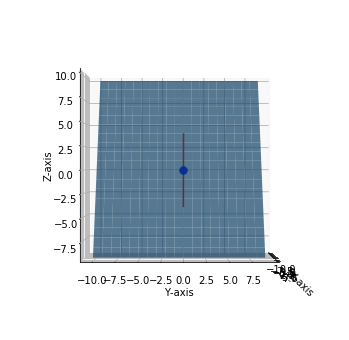

0.0 10.0


In [26]:
plot_plane(normal)
print(angle, dist)